In [1]:
!pip install boto3
!pip install tqdm
!pip install requests
!pip install pandas
!pip install opencv-python

In [2]:
import ast
import os
import shutil
import argparse
import sys

import requests

import pandas as pd


def process(classes, data_out_dir, yolov8_format, max_number_images_per_class):

    if max_number_images_per_class is None:
        max_number_images_per_class = sys.maxsize

    train_data_url = 'https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv'
    val_data_url = 'https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv'
    test_data_url = 'https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv'

    downloader_url = 'https://raw.githubusercontent.com/openimages/dataset/master/downloader.py'

    class_names_all_url = 'https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions.csv'

    for url in [train_data_url, val_data_url, test_data_url, class_names_all_url, downloader_url]:
        if not os.path.exists(url.split('/')[-1]):
            print('downloading {}...'.format(url.split('/')[-1]))
            r = requests.get(url)
            with open(url.split('/')[-1], 'wb') as f:
                f.write(r.content)

    class_ids = []

    classes_all = pd.read_csv(class_names_all_url.split('/')[-1])

    for class_ in classes:
        if class_ not in list(classes_all['DisplayName']) or class_ not in list(classes_all['DisplayName']):
            raise Exception('Class name not found: {}'.format(class_))
        class_index = list(classes_all['DisplayName']).index(class_)
        class_ids.append(classes_all['LabelName'].iloc[class_index])

    image_list_file_path = os.path.join('.', 'image_list_file')
    if os.path.exists(image_list_file_path):
        os.remove(image_list_file_path)


    image_list_file_list = []
    for j, url in enumerate([train_data_url, val_data_url, test_data_url]):
        image_list_file_per_class = [[] for j in class_ids]
        filename = url.split('/')[-1]
        with (open(filename, 'r') as f):
            line = f.readline()
            while len(line) != 0:
                id, _, class_name, _, x1, x2, y1, y2, _, _, _, _, _ = line.split(',')[:13]
                if class_name in class_ids and id not in image_list_file_list \
                    and len(image_list_file_per_class[class_ids.index(class_name)]) < max_number_images_per_class:
                    image_list_file_list.append(id)
                    image_list_file_per_class[class_ids.index(class_name)].append(id)
                    with open(image_list_file_path, 'a') as fw:
                        fw.write('{}/{}\n'.format(['train', 'validation', 'test'][j], id))
                line = f.readline()

            f.close()

    out_dir = './.out'
    shutil.rmtree(out_dir, ignore_errors=True)
    os.system('python downloader.py {} --download_folder={}'.format(image_list_file_path, out_dir))

    DATA_ALL_DIR = out_dir

    for set_ in ['train', 'val', 'test']:
        for dir_ in [os.path.join(data_out_dir, set_),
                     os.path.join(data_out_dir, set_, 'imgs'),
                     os.path.join(data_out_dir, set_, 'anns')]:
            if os.path.exists(dir_):
                shutil.rmtree(dir_)
            os.makedirs(dir_)

    for j, url in enumerate([train_data_url, val_data_url, test_data_url]):
        filename = url.split('/')[-1]
        set_ = ['train', 'val', 'test'][j]
        print(filename)
        with open(filename, 'r') as f:
            line = f.readline()
            while len(line) != 0:
                id, _, class_name, _, x1, x2, y1, y2, _, _, _, _, _ = line.split(',')[:13]
                if class_name in class_ids:
                    if os.path.exists(os.path.join(DATA_ALL_DIR, '{}.jpg'.format(id))):
                        if not os.path.exists(os.path.join(data_out_dir, set_, 'imgs', '{}.jpg'.format(id))):
                            shutil.copy(os.path.join(DATA_ALL_DIR, '{}.jpg'.format(id)),
                                        os.path.join(data_out_dir, set_, 'imgs', '{}.jpg'.format(id)))
                        with open(os.path.join(data_out_dir, set_, 'anns', '{}.txt'.format(id)), 'a') as f_ann:
                            # class_id, xc, yx, w, h
                            x1, x2, y1, y2 = [float(j) for j in [x1, x2, y1, y2]]
                            xc = (x1 + x2) / 2
                            yc = (y1 + y2) / 2
                            w = x2 - x1
                            h = y2 - y1

                            f_ann.write('{} {} {} {} {}\n'.format(int(class_ids.index(class_name)), xc, yc, w, h))
                            f_ann.close()

                line = f.readline()

    shutil.rmtree(out_dir, ignore_errors=True)

    if yolov8_format:
        for set_ in ['train', 'val', 'test']:
            for dir_ in [os.path.join(data_out_dir, 'images', set_),
                         os.path.join(data_out_dir, 'labels', set_)]:
                if os.path.exists(dir_):
                    shutil.rmtree(dir_)
                os.makedirs(dir_)

            for filename in os.listdir(os.path.join(data_out_dir, set_, 'imgs')):
                shutil.copy(os.path.join(data_out_dir, set_, 'imgs', filename), os.path.join(data_out_dir, 'images', set_, filename))
            for filename in os.listdir(os.path.join(data_out_dir, set_, 'anns')):
                shutil.copy(os.path.join(data_out_dir, set_, 'anns', filename), os.path.join(data_out_dir, 'labels', set_, filename))

            shutil.rmtree(os.path.join(data_out_dir, set_))


In [3]:
classes = ['Duck', 'Dog']  # list containing all the classes you will download from the open images dataset v7

out_dir = './data'

max_number_images_per_class = 200

yolov8_format = True

process(classes, out_dir, yolov8_format, max_number_images_per_class)

downloading oidv6-train-annotations-bbox.csv...
downloading validation-annotations-bbox.csv...
downloading test-annotations-bbox.csv...
downloading oidv7-class-descriptions.csv...
downloading downloader.py...
oidv6-train-annotations-bbox.csv
validation-annotations-bbox.csv
test-annotations-bbox.csv


In [4]:
# zip the data directory

!zip -r data.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/labels/ (stored 0%)
  adding: content/data/labels/train/ (stored 0%)
  adding: content/data/labels/train/0008cf211699d6a5.txt (deflated 24%)
  adding: content/data/labels/train/006487b7dbf9fc7a.txt (deflated 54%)
  adding: content/data/labels/train/00609ac7507e641e.txt (deflated 41%)
  adding: content/data/labels/train/000a3f4144bf73ba.txt (deflated 10%)
  adding: content/data/labels/train/008671b11cf951d6.txt (deflated 23%)
  adding: content/data/labels/train/00126bd470298515.txt (deflated 10%)
  adding: content/data/labels/train/016314b436517a4b.txt (deflated 28%)
  adding: content/data/labels/train/0087ddea28745b74.txt (deflated 20%)
  adding: content/data/labels/train/00627b414a83375e.txt (deflated 23%)
  adding: content/data/labels/train/0235dd1107f59685.txt (deflated 24%)
  adding: content/data/labels/train/0117af10b2079d43.txt (deflated 67%)
  adding: content/data/labels/train/03184e80bfd7e497.txt (deflated 72%)
  adding

In [5]:
# mount Google Drive

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!scp '/content/data.zip' '/content/gdrive/My Drive/data.zip'

In [7]:
!pip -q install ultralytics opencv-python matplotlib pandas numpy pyyaml

import os, glob, time, yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
DATA_ROOT = "data"  # ✅ based on your screenshot (folder is named data)

paths = {
    "train_img": os.path.join(DATA_ROOT, "images", "train"),
    "val_img":   os.path.join(DATA_ROOT, "images", "val"),
    "test_img":  os.path.join(DATA_ROOT, "images", "test"),
    "train_lbl": os.path.join(DATA_ROOT, "labels", "train"),
    "val_lbl":   os.path.join(DATA_ROOT, "labels", "val"),
    "test_lbl":  os.path.join(DATA_ROOT, "labels", "test"),
}

for k, p in paths.items():
    print(f"{k}: {p} ->", "✅" if os.path.isdir(p) else "❌")

for split in ["train", "val", "test"]:
    n_imgs = len(glob.glob(os.path.join(DATA_ROOT, "images", split, "*.jpg")))
    n_lbls = len(glob.glob(os.path.join(DATA_ROOT, "labels", split, "*.txt")))
    print(f"{split}: images={n_imgs}, labels={n_lbls}")


train_img: data/images/train -> ✅
val_img: data/images/val -> ✅
test_img: data/images/test -> ✅
train_lbl: data/labels/train -> ✅
val_lbl: data/labels/val -> ✅
test_lbl: data/labels/test -> ✅
train: images=400, labels=400
val: images=268, labels=268
test: images=399, labels=399


In [9]:
data_yaml = {
    "path": DATA_ROOT,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {1: "Dog", 0: "Duck"}
}

YAML_PATH = "dog_duck.yaml"
with open(YAML_PATH, "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print(open(YAML_PATH).read())


path: data
train: images/train
val: images/val
test: images/test
names:
  1: Dog
  0: Duck



In [10]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


### Train YOLOv8n

In [12]:
model_n = YOLO("yolov8n.pt")

model_n.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=640,
    batch=16,
    workers = 2,
    project="runs_compare",
    name="yolov8n_dog_duck"
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dog_duck.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_dog_duck, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dce5b3224b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### Train YOLOv8s

In [16]:
model_s = YOLO("yolov8s.pt")

model_s.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=640,
    batch=16,
    workers = 2,
    project="runs_compare",
    name="yolov8n_dog_duck"
)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dog_duck.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_dog_duck3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dce5a287fe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### Evaluate both models on Val and Test

In [17]:
val_n  = model_n.val(data=YAML_PATH, split="val")
test_n = model_n.val(data=YAML_PATH, split="test")

val_s  = model_s.val(data=YAML_PATH, split="val")
test_s = model_s.val(data=YAML_PATH, split="test")

print("v8n val:",  val_n.results_dict)
print("v8n test:", test_n.results_dict)
print("v8s val:",  val_s.results_dict)
print("v8s test:", test_s.results_dict)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2511.6±807.7 MB/s, size: 384.4 KB)
val: Scanning /content/data/labels/val.cache... 268 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 268/268 502.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        268        396      0.812      0.718      0.782      0.513
                  Duck         68        149      0.793      0.642      0.726      0.479
                   Dog        200        247      0.831      0.794      0.839      0.547
Speed: 3.1ms preprocess, 6.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/runs/detect/val3
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1665.2±684.1 MB/s, size: 276.1 KB)
val: Scanning /co

### Make a clean split-wise comparison table

In [19]:
import pandas as pd

def extract(m):
    d = m.results_dict
    return {
        "Precision": d.get("metrics/precision(B)"),
        "Recall": d.get("metrics/recall(B)"),
        "mAP50": d.get("metrics/mAP50(B)"),
        "mAP50-95": d.get("metrics/mAP50-95(B)")
    }

split_table = pd.DataFrame([
    {"Model":"YOLOv8n","Split":"val",  **extract(val_n)},
    {"Model":"YOLOv8n","Split":"test", **extract(test_n)},
    {"Model":"YOLOv8s","Split":"val",  **extract(val_s)},
    {"Model":"YOLOv8s","Split":"test", **extract(test_s)},
])

split_table


,Model,Split,Precision,Recall,mAP50,mAP50-95
0,YOLOv8n,val,0.811633,0.717727,0.782223,0.512970
1,YOLOv8n,test,0.762414,0.740514,0.786869,0.513355
2,YOLOv8s,val,0.811633,0.717727,0.782223,0.512970
3,YOLOv8s,test,0.762414,0.740514,0.786869,0.513355


### Benchmark inference speed

In [22]:
val_imgs = sorted(glob.glob(os.path.join(paths["val_img"], "*.jpg")))[:100]

def speed(model, imgs, conf=0.25):
    t0 = time.time()
    _ = model.predict(source=imgs, conf=conf, verbose=False)
    t1 = time.time()
    return (t1 - t0) / len(imgs)

sec_n = speed(model_n, val_imgs)
sec_s = speed(model_s, val_imgs)

print("YOLOv8n sec/img:", sec_n)
print("YOLOv8s sec/img:", sec_s)


YOLOv8n sec/img: 0.028686418533325195
YOLOv8s sec/img: 0.026897413730621336


###Object scale analysis

In [23]:
def load_yolo_txt(txt_path):
    # returns list of (cls, xyxy_norm, area_norm)
    out = []
    if not os.path.exists(txt_path):
        return out
    with open(txt_path, "r") as f:
        for line in f:
            p = line.strip().split()
            if len(p) != 5:
                continue
            cls = int(float(p[0]))
            xc, yc, w, h = map(float, p[1:])
            x1, y1 = xc - w/2, yc - h/2
            x2, y2 = xc + w/2, yc + h/2
            out.append((cls, np.array([x1,y1,x2,y2], float), w*h))
    return out

def iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-12)


###Compute recall for small vs large objects

In [24]:
def bucket(area, thr=0.02):
    return "small" if area < thr else "large"

def scale_recall(model, img_dir, lbl_dir, conf=0.25, iou_thr=0.5, area_thr=0.02, max_imgs=200):
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))[:max_imgs]
    total = {"small":0, "large":0}
    matched = {"small":0, "large":0}

    preds = model.predict(source=imgs, conf=conf, verbose=False, stream=True)

    for r in preds:
        stem = os.path.splitext(os.path.basename(r.path))[0]
        gt_path = os.path.join(lbl_dir, stem + ".txt")
        gt = load_yolo_txt(gt_path)
        if not gt:
            continue

        for (gcls, gbox, garea) in gt:
            total[bucket(garea, area_thr)] += 1

        if r.boxes is None or len(r.boxes) == 0:
            continue

        p_xyxy = r.boxes.xyxyn.cpu().numpy()
        p_cls = r.boxes.cls.cpu().numpy().astype(int)

        used = [False]*len(gt)

        for pi in range(len(p_xyxy)):
            best_iou, best_gi = 0.0, -1
            for gi,(gcls,gbox,garea) in enumerate(gt):
                if used[gi] or p_cls[pi] != gcls:
                    continue
                v = iou(p_xyxy[pi], gbox)
                if v > best_iou:
                    best_iou, best_gi = v, gi
            if best_gi >= 0 and best_iou >= iou_thr:
                used[best_gi] = True
                _,_,garea = gt[best_gi]
                matched[bucket(garea, area_thr)] += 1

    return {
        "total_small": total["small"], "matched_small": matched["small"],
        "recall_small": matched["small"]/max(1,total["small"]),
        "total_large": total["large"], "matched_large": matched["large"],
        "recall_large": matched["large"]/max(1,total["large"])
    }

scale_n = scale_recall(model_n, paths["val_img"], paths["val_lbl"])
scale_s = scale_recall(model_s, paths["val_img"], paths["val_lbl"])

scale_n, scale_s


({'total_small': 23,
  'matched_small': 6,
  'recall_small': 0.2608695652173913,
  'total_large': 237,
  'matched_large': 206,
  'recall_large': 0.869198312236287},
 {'total_small': 23,
  'matched_small': 6,
  'recall_small': 0.2608695652173913,
  'total_large': 237,
  'matched_large': 206,
  'recall_large': 0.869198312236287})

### Final combined comparison table

In [25]:
final = pd.DataFrame([
    {
        "Model": "YOLOv8n",
        "Val mAP50": extract(val_n)["mAP50"],
        "Test mAP50": extract(test_n)["mAP50"],
        "Recall small (val)": scale_n["recall_small"],
        "Recall large (val)": scale_n["recall_large"],
        "sec/img (val)": sec_n
    },
    {
        "Model": "YOLOv8s",
        "Val mAP50": extract(val_s)["mAP50"],
        "Test mAP50": extract(test_s)["mAP50"],
        "Recall small (val)": scale_s["recall_small"],
        "Recall large (val)": scale_s["recall_large"],
        "sec/img (val)": sec_s
    }
])

final


,Model,Val mAP50,Test mAP50,Recall small (val),Recall large (val),sec/img (val)
0,YOLOv8n,0.782223,0.786869,0.26087,0.869198,0.028686
1,YOLOv8s,0.782223,0.786869,0.26087,0.869198,0.026897


### Simple plot

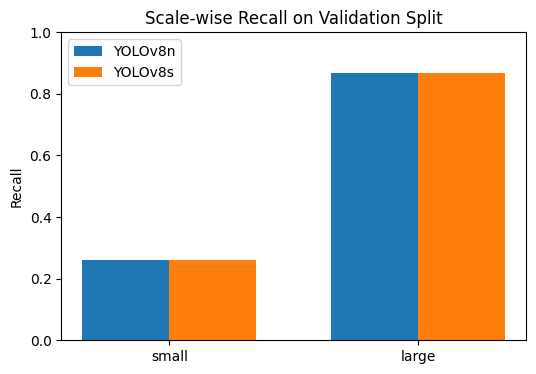

In [26]:
labels = ["small", "large"]
n_vals = [scale_n["recall_small"], scale_n["recall_large"]]
s_vals = [scale_s["recall_small"], scale_s["recall_large"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, n_vals, w, label="YOLOv8n")
plt.bar(x + w/2, s_vals, w, label="YOLOv8s")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Recall")
plt.title("Scale-wise Recall on Validation Split")
plt.legend()
plt.show()


In [27]:
samples = sorted(glob.glob(os.path.join(paths["val_img"], "*.jpg")))[:10]

model_n.predict(source=samples, save=True, project="runs_compare", name="pred_v8n_samples", verbose=False)
model_s.predict(source=samples, save=True, project="runs_compare", name="pred_v8s_samples", verbose=False)

print("Check folders:")
print("runs_compare/pred_v8n_samples/")
print("runs_compare/pred_v8s_samples/")


Results saved to /content/runs_compare/pred_v8n_samples
Results saved to /content/runs_compare/pred_v8s_samples
Check folders:
runs_compare/pred_v8n_samples/
runs_compare/pred_v8s_samples/


In [28]:
CLASS_NAMES = {0: "Duck", 1: "Dog"}


In [29]:
def classwise_recall(model, img_dir, lbl_dir, conf=0.25, iou_thr=0.5, max_imgs=200):
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))[:max_imgs]

    total = {0: 0, 1: 0}     # 0=Duck, 1=Dog
    matched = {0: 0, 1: 0}

    preds = model.predict(source=imgs, conf=conf, verbose=False, stream=True)

    for r in preds:
        stem = os.path.splitext(os.path.basename(r.path))[0]
        gt_path = os.path.join(lbl_dir, stem + ".txt")
        gt = load_yolo_txt(gt_path)
        if not gt:
            continue

        # Count GT per class
        for gcls, gbox, garea in gt:
            if gcls in total:
                total[gcls] += 1

        # No predictions -> skip matching
        if r.boxes is None or len(r.boxes) == 0:
            continue

        p_xyxy = r.boxes.xyxyn.cpu().numpy()
        p_cls  = r.boxes.cls.cpu().numpy().astype(int)

        used = [False] * len(gt)

        # Greedy IoU matching within same class
        for pi in range(len(p_xyxy)):
            best_iou, best_gi = 0.0, -1
            for gi, (gcls, gbox, garea) in enumerate(gt):
                if used[gi]:
                    continue
                if p_cls[pi] != gcls:
                    continue
                v = iou(p_xyxy[pi], gbox)
                if v > best_iou:
                    best_iou, best_gi = v, gi

            if best_gi >= 0 and best_iou >= iou_thr:
                used[best_gi] = True
                matched[gt[best_gi][0]] += 1

    # Convert to recalls
    recall_duck = matched[0] / max(1, total[0])
    recall_dog  = matched[1] / max(1, total[1])

    return {
        "Duck total": total[0],
        "Dog total": total[1],
        "Duck recall": recall_duck,
        "Dog recall": recall_dog
    }


In [30]:
cls_n = classwise_recall(model_n, paths["val_img"], paths["val_lbl"], max_imgs=200)
cls_s = classwise_recall(model_s, paths["val_img"], paths["val_lbl"], max_imgs=200)

cls_n, cls_s


({'Duck total': 22,
  'Dog total': 238,
  'Duck recall': 0.36363636363636365,
  'Dog recall': 0.8571428571428571},
 {'Duck total': 22,
  'Dog total': 238,
  'Duck recall': 0.36363636363636365,
  'Dog recall': 0.8571428571428571})

In [31]:
class_table = pd.DataFrame([
    {"Model": "YOLOv8n", **cls_n},
    {"Model": "YOLOv8s", **cls_s}
])

class_table


,Model,Duck total,Dog total,Duck recall,Dog recall
0,YOLOv8n,22,238,0.363636,0.857143
1,YOLOv8s,22,238,0.363636,0.857143
